# FIONA: Fresnel Integral Optimization via Non-uniform trAnforms

We compute the complex Fresnel diffraction integral for a lensing potential
$\psi(\mathbf{x})$ in two transverse dimensions. The target quantity is the
dimensionless amplification factor

$$
F(\mathbf{y}, w),
$$

evaluated at source position $\mathbf{y} = (y_1, y_2)$ and dimensionless
frequency $w \neq 0$.

---

### 1. Fresnel Integral Representation

The Fresnel diffraction integral is written as

$$
F(\mathbf{y}, w)
=
\frac{1}{i w \, 2\pi}
\exp\!\left( \frac{i w}{2} |\mathbf{y}|^2 \right)
\int_{\mathbb{R}^2} \mathrm{d}^2\mathbf{u}\;
\exp\!\left[
i \left(
\frac{|\mathbf{u}|^2}{2w}
- w\,\psi\!\left(\frac{\mathbf{u}}{w}\right)
- \mathbf{u}\cdot\mathbf{y}
\right)
\right].
$$

---

### 2. Finite-Domain Quadrature (“Core” Integral)

The integral is approximated over a finite domain
$|\mathbf{u}| \le U_{\max}$ using Gauss–Legendre quadrature:

$$
\int_{|\mathbf{u}| \le U_{\max}} \mathrm{d}^2\mathbf{u}\; f(\mathbf{u})
\;\approx\;
\sum_{j=1}^{N} W_j\, f(\mathbf{u}_j),
$$

where $\{\mathbf{u}_j = (u_{1j}, u_{2j})\}$ and $\{W_j\}$ are quadrature nodes
and weights (Cartesian or polar).

Define the phase

$$
\Phi_j(w)
=
\frac{|\mathbf{u}_j|^2}{2w}
-
w\,\psi\!\left(\frac{\mathbf{u}_j}{w}\right),
$$

and the complex coefficients

$$
c_j(w) = W_j \, e^{i \Phi_j(w)}.
$$

The truncated (“core”) integral is then

$$
I_{\text{core}}(\mathbf{y}, w)
=
\sum_{j=1}^{N}
c_j(w)\,
e^{-i \mathbf{u}_j \cdot \mathbf{y}}.
$$

This sum is evaluated efficiently using a **type-3 NUFFT**.

The corresponding Fresnel amplification from the finite domain is

$$
F_{\text{core}}(\mathbf{y}, w)
=
\frac{1}{i w \, 2\pi}
\exp\!\left( \frac{i w}{2} |\mathbf{y}|^2 \right)
I_{\text{core}}(\mathbf{y}, w).
$$

---

### 3. Free (Unlensed) Fresnel Integral

For the *free* case $\psi \equiv 0$, the phase reduces to

$$
\Phi^{(0)}_j(w) = \frac{|\mathbf{u}_j|^2}{2w}.
$$

Using the same quadrature nodes and weights, the truncated free integral is

$$
I^{(0)}_{\text{core}}(\mathbf{y}, w)
=
\sum_{j=1}^{N}
W_j \,
\exp\!\left(
i \frac{|\mathbf{u}_j|^2}{2w}
- i \mathbf{u}_j \cdot \mathbf{y}
\right),
$$

with corresponding Fresnel factor

$$
F^{(0)}_{\text{core}}(\mathbf{y}, w)
=
\frac{1}{i w \, 2\pi}
\exp\!\left( \frac{i w}{2} |\mathbf{y}|^2 \right)
I^{(0)}_{\text{core}}(\mathbf{y}, w).
$$

---

### 4. Analytic Tail Subtraction

The exact free Fresnel integral over $\mathbb{R}^2$ is known analytically:

$$
F^{(0)}(\mathbf{y}, w) = 1.
$$

Therefore, the contribution from the excluded region
$|\mathbf{u}| > U_{\max}$ is

$$
F^{(0)}_{\text{tail}}(\mathbf{y}, w)
=
1 - F^{(0)}_{\text{core}}(\mathbf{y}, w).
$$

Assuming that lensing effects vanish asymptotically
($\psi(\mathbf{x}) \to 0$ as $|\mathbf{x}| \to \infty$),
this free tail provides an accurate approximation to the full tail of the
lensed integral.

---

### 5. Final Fresnel Amplification

The final result returned by the algorithm is

$$
F(\mathbf{y}, w)
=
F_{\text{core}}(\mathbf{y}, w)
+
\left[
1 - F^{(0)}_{\text{core}}(\mathbf{y}, w)
\right].
$$

This formulation:
- uses NUFFT only on the finite domain,
- restores the correct normalization at infinity,
- and dramatically reduces sensitivity to the choice of $U_{\max}$.

In [1]:
# Uising FIONA v.0.1.1

import os
os.environ["FIONA_GL2D_DIR"] = "/n/netscratch/dvorkin_lab/Lab/nephremidze/2-LISA/0-fiona/gl_quads"
os.environ["FIONA_GL2D_STRICT"] = "0"
os.environ["OMP_NUM_THREADS"] = "112"

import pathlib, time, numpy as np, matplotlib.pyplot as plt
from fiona import SIS, set_num_threads, FresnelNUFFT3
from fiona.utils import *

from glow import lenses as glow_lenses
from glow import time_domain_c, freq_domain_c

set_num_threads(112)

def plot_overlays_ws(ws, F_fift, F_glow, quad_label, Umax,
                     title="F(w) overlay", align_phase=True):
    """
    Quick overlay plot for scalar F(w) from FIONA vs GLoW.
    quad_label: string describing quadrature resolution, e.g.
        "N_gl=128" or "N_r=4000, N_theta=100"
    """
    if align_phase:
        F_fift_al, _ = align_global_phase(F_fift, F_glow)
    else:
        F_fift_al = F_fift

    plt.figure()
    plt.loglog(ws, np.abs(F_fift_al), '-', label='FIONA', color='orchid')
    plt.loglog(ws, np.abs(F_glow), '--', label='GLoW', color='royalblue')
    plt.xlabel('w')
    plt.ylabel('|F(w)|')
    plt.legend()
    plt.title(f"{title}; {quad_label}, U={Umax}")
    plt.show()

def compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                            w_grid=np.logspace(-1.0, 1.0, 50),
                            y_star=1.2,
                            n_gl=1000,
                            Umax=50.0,
                            eps=1e-12,
                            shared_Umax=True,
                            numexpr_threads=None,
                            track_perf=True,
                            polar_coord=False,
                            n_r=None,
                            n_theta=None,
                            uniform_theta=False,
                            analytic_tail=True):

    fiona_gl2d_dir = os.environ.get("FIONA_GL2D_DIR")
    # check_precomputed_gl_files(n_gl, Umax, fiona_gl2d_dir)

    # Build a label for the plot title depending on quadrature mode
    if polar_coord:
        quad_label = f"$N_r={n_r}$, $N_{{\\theta}}={n_theta}$"
    else:
        quad_label = f"$N_{{GL}}={n_gl}$"

    t0 = time.perf_counter()
    nu3v = FresnelNUFFT3(
        lens,
        n_gl=n_gl,
        Umax=Umax,
        eps=eps,
        shared_Umax=shared_Umax,
        numexpr_threads=numexpr_threads,
        track_perf=track_perf,
        polar_coord=polar_coord,
        n_r=n_r,
        n_theta=n_theta,
        uniform_theta=uniform_theta,
        analytic_tail=analytic_tail
    )

    F_fiona = nu3v(w_grid, np.array([y_star]), np.array([0.0]))[:, 0]
    t1 = time.perf_counter()
    fiona_s = t1 - t0

    t2 = time.perf_counter()
    Psi = glow_lenses.Psi_SIS({'psi0': 1.0}, {})
    It  = time_domain_c.It_MultiContour_C(Psi, y=y_star)
    Fw  = freq_domain_c.Fw_FFT_C(It)
    F_glow = Fw(w_grid)
    t3 = time.perf_counter()
    glow_s = t3 - t2

    plot_overlays_ws(
        w_grid, F_fiona, F_glow,
        quad_label=quad_label,
        Umax=Umax,
        title=f"SIS @ y={y_star}",
        align_phase=True
    )

    print(f"FIONA time (single run): {fiona_s:.4f} s")
    print(f"GLoW time (single run): {glow_s:.4f} s")
    print(f"Speedup (GLoW/FIONA): {glow_s/fiona_s:.2f}×")


Error.  nthreads cannot be larger than environment variable "NUMEXPR_MAX_THREADS" (64)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


# Cartesian Gauss-Legendre Nodes

## Finite-domain integral

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 39.78 cores over 0.824s (35.5% of 112 logical cores; CPU sec=32.764)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 10.58 cores over 1.292s (9.4% of 112 logical cores; CPU sec=13.666)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   1.11%  (  0.014370 s)

    2b. Coefficient build (total)   :  98.89%  (  1.277167 s)
        ├─ scale u/w (all w)        :   4.53%  (  0.058477 s)
        ├─ lens potential ψ(x)      :   3.72%  (  0.048036 s)
        ├─ phase calculation        :   2.53%  (  0.032631 s)
        ├─ exp(i·phase)             :  88.11%  (  1.137967 s)
        └─ unaccounted              :   0.00%  (  0.000056 s)

  Step 2 total                      : 100.00%  (  1.291538 s)
───────────────────────────────────────────────────────

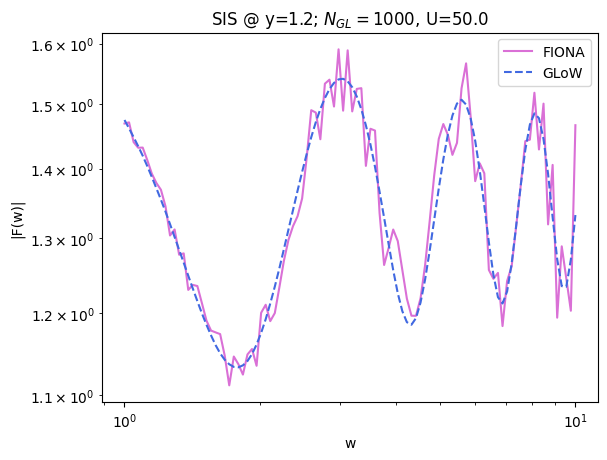

FIONA time (single run): 2.1776 s
GLoW time (single run): 0.0721 s
Speedup (GLoW/FIONA): 0.03×


In [2]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        n_gl = 1000,
                        w_grid = np.logspace(0., 1., 100),
                        y_star = 1.2,
                        Umax=50.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=False,
                        analytic_tail=False)

## Oscillatory tail correction

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 41.98 cores over 0.692s (37.5% of 112 logical cores; CPU sec=29.042)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 10.44 cores over 1.254s (9.3% of 112 logical cores; CPU sec=13.092)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   1.22%  (  0.015301 s)

    2b. Coefficient build (total)   :  98.78%  (  1.238832 s)
        ├─ scale u/w (all w)        :   3.08%  (  0.038601 s)
        ├─ lens potential ψ(x)      :   3.57%  (  0.044728 s)
        ├─ phase calculation        :   2.99%  (  0.037501 s)
        ├─ exp(i·phase)             :  89.14%  (  1.117944 s)
        └─ unaccounted              :   0.00%  (  0.000058 s)

  Step 2 total                      : 100.00%  (  1.254134 s)
───────────────────────────────────────────────────────

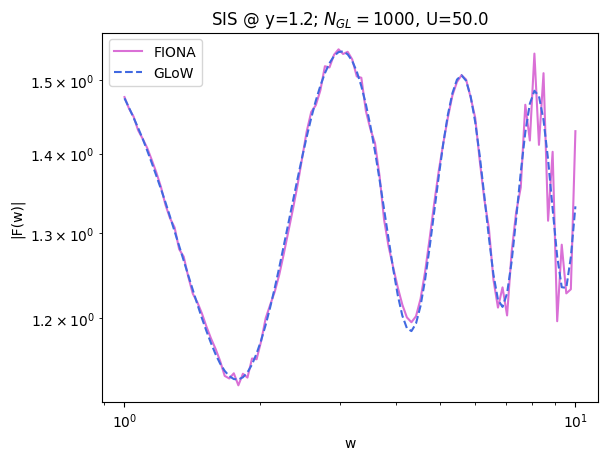

FIONA time (single run): 3.8705 s
GLoW time (single run): 0.0235 s
Speedup (GLoW/FIONA): 0.01×


In [3]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        n_gl = 1000,
                        w_grid = np.logspace(0., 1., 100),
                        y_star = 1.2,
                        Umax=50.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=False,
                        analytic_tail=True)

# Polar Gauss-Legendre Nodes

## Trapezoidal quadrature in $\theta$

### Finite-domain

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 69.58 cores over 0.308s (62.1% of 112 logical cores; CPU sec=21.435)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 17.89 cores over 0.326s (16.0% of 112 logical cores; CPU sec=5.829)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.24%  (  0.000787 s)

    2b. Coefficient build (total)   :  99.76%  (  0.324811 s)
        ├─ scale u/w (all w)        :   8.74%  (  0.028452 s)
        ├─ lens potential ψ(x)      :  10.53%  (  0.034293 s)
        ├─ phase calculation        :   4.22%  (  0.013739 s)
        ├─ exp(i·phase)             :  76.26%  (  0.248295 s)
        └─ unaccounted              :   0.01%  (  0.000032 s)

  Step 2 total                      : 100.00%  (  0.325598 s)
───────────────────────────────────────────────────────

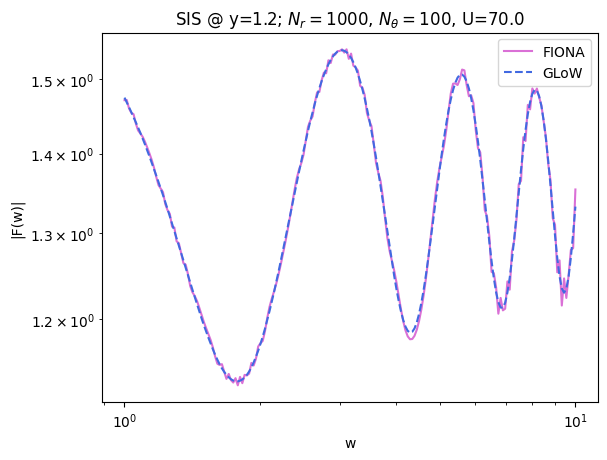

FIONA time (single run): 0.6661 s
GLoW time (single run): 0.0228 s
Speedup (GLoW/FIONA): 0.03×


In [4]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=70.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=100,
                        uniform_theta=True,
                        analytic_tail=False)

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 59.05 cores over 0.207s (52.7% of 112 logical cores; CPU sec=12.237)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 17.53 cores over 0.324s (15.7% of 112 logical cores; CPU sec=5.678)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.24%  (  0.000763 s)

    2b. Coefficient build (total)   :  99.76%  (  0.322815 s)
        ├─ scale u/w (all w)        :   8.52%  (  0.027579 s)
        ├─ lens potential ψ(x)      :   7.24%  (  0.023420 s)
        ├─ phase calculation        :   3.65%  (  0.011815 s)
        ├─ exp(i·phase)             :  80.34%  (  0.259969 s)
        └─ unaccounted              :   0.01%  (  0.000032 s)

  Step 2 total                      : 100.00%  (  0.323578 s)
───────────────────────────────────────────────────────

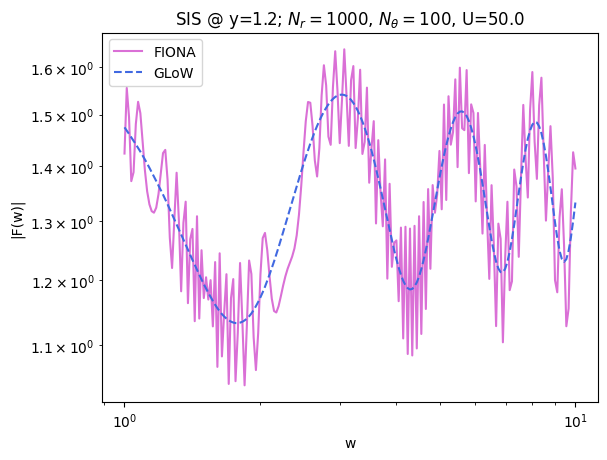

FIONA time (single run): 0.5583 s
GLoW time (single run): 0.0080 s
Speedup (GLoW/FIONA): 0.01×


In [5]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=50.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=100,
                        uniform_theta=True,
                        analytic_tail=False)

## Oscillatory tail correction

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 61.92 cores over 0.203s (55.3% of 112 logical cores; CPU sec=12.587)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 17.24 cores over 0.324s (15.4% of 112 logical cores; CPU sec=5.580)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.17%  (  0.000563 s)

    2b. Coefficient build (total)   :  99.83%  (  0.322885 s)
        ├─ scale u/w (all w)        :   8.01%  (  0.025917 s)
        ├─ lens potential ψ(x)      :   7.36%  (  0.023805 s)
        ├─ phase calculation        :   3.46%  (  0.011203 s)
        ├─ exp(i·phase)             :  80.98%  (  0.261919 s)
        └─ unaccounted              :   0.01%  (  0.000041 s)

  Step 2 total                      : 100.00%  (  0.323449 s)
───────────────────────────────────────────────────────

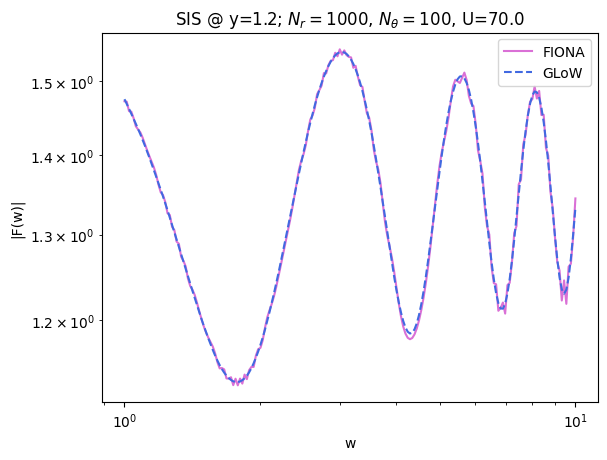

FIONA time (single run): 1.1297 s
GLoW time (single run): 0.0207 s
Speedup (GLoW/FIONA): 0.02×


In [6]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=70.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=100,
                        uniform_theta=True,
                        analytic_tail=True)

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 57.14 cores over 0.771s (51.0% of 112 logical cores; CPU sec=44.069)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 8.44 cores over 1.899s (7.5% of 112 logical cores; CPU sec=16.033)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.28%  (  0.005297 s)

    2b. Coefficient build (total)   :  99.72%  (  1.893031 s)
        ├─ scale u/w (all w)        :   2.59%  (  0.049157 s)
        ├─ lens potential ψ(x)      :   3.45%  (  0.065441 s)
        ├─ phase calculation        :   1.65%  (  0.031387 s)
        ├─ exp(i·phase)             :  92.03%  (  1.747009 s)
        └─ unaccounted              :   0.00%  (  0.000036 s)

  Step 2 total                      : 100.00%  (  1.898329 s)
────────────────────────────────────────────────────────

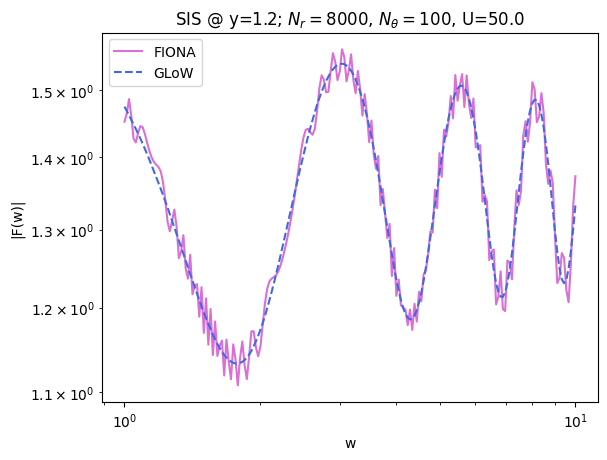

FIONA time (single run): 5.1319 s
GLoW time (single run): 0.0148 s
Speedup (GLoW/FIONA): 0.00×


In [7]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=50.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=8000,
                        n_theta=100,
                        uniform_theta=True,
                        analytic_tail=True)

## Gauss-Legendre quadrature in $\theta$

Requires a higher number of nodes than a trapezoidal quadrature.

## Finite-domain

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 62.70 cores over 0.257s (56.0% of 112 logical cores; CPU sec=16.082)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 18.28 cores over 0.320s (16.3% of 112 logical cores; CPU sec=5.844)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.17%  (  0.000528 s)

    2b. Coefficient build (total)   :  99.83%  (  0.318984 s)
        ├─ scale u/w (all w)        :   8.09%  (  0.025855 s)
        ├─ lens potential ψ(x)      :   7.84%  (  0.025061 s)
        ├─ phase calculation        :   3.89%  (  0.012426 s)
        ├─ exp(i·phase)             :  80.00%  (  0.255602 s)
        └─ unaccounted              :   0.01%  (  0.000040 s)

  Step 2 total                      : 100.00%  (  0.319512 s)
───────────────────────────────────────────────────────

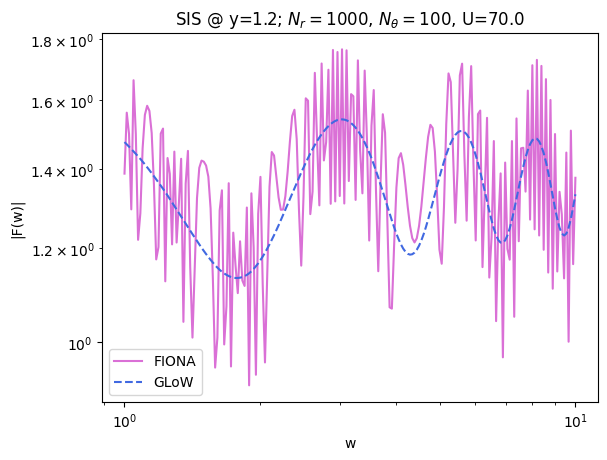

FIONA time (single run): 0.6039 s
GLoW time (single run): 0.0089 s
Speedup (GLoW/FIONA): 0.01×


In [8]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=70.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=100,
                        uniform_theta=False,
                        analytic_tail=False)

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 63.84 cores over 0.526s (57.0% of 112 logical cores; CPU sec=33.555)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 9.74 cores over 1.178s (8.7% of 112 logical cores; CPU sec=11.474)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.26%  (  0.003024 s)

    2b. Coefficient build (total)   :  99.74%  (  1.174896 s)
        ├─ scale u/w (all w)        :   3.22%  (  0.037970 s)
        ├─ lens potential ψ(x)      :   3.76%  (  0.044331 s)
        ├─ phase calculation        :   2.26%  (  0.026663 s)
        ├─ exp(i·phase)             :  90.49%  (  1.065900 s)
        └─ unaccounted              :   0.00%  (  0.000032 s)

  Step 2 total                      : 100.00%  (  1.177921 s)
────────────────────────────────────────────────────────

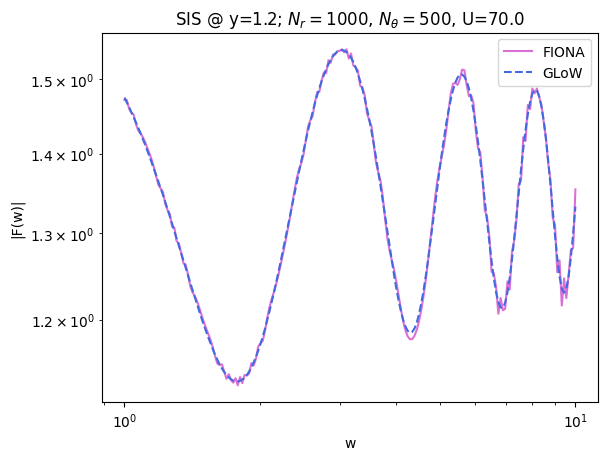

FIONA time (single run): 1.7797 s
GLoW time (single run): 0.0160 s
Speedup (GLoW/FIONA): 0.01×


In [9]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=70.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=500,
                        uniform_theta=False,
                        analytic_tail=False)

## Oscillatory tail correction

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 58.88 cores over 0.248s (52.6% of 112 logical cores; CPU sec=14.591)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 16.69 cores over 0.339s (14.9% of 112 logical cores; CPU sec=5.654)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.18%  (  0.000602 s)

    2b. Coefficient build (total)   :  99.82%  (  0.337821 s)
        ├─ scale u/w (all w)        :   7.88%  (  0.026674 s)
        ├─ lens potential ψ(x)      :   7.03%  (  0.023793 s)
        ├─ phase calculation        :   3.31%  (  0.011213 s)
        ├─ exp(i·phase)             :  81.58%  (  0.276102 s)
        └─ unaccounted              :   0.01%  (  0.000039 s)

  Step 2 total                      : 100.00%  (  0.338424 s)
───────────────────────────────────────────────────────

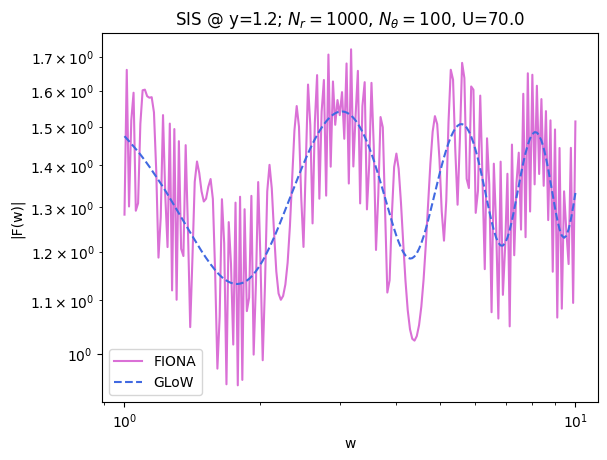

FIONA time (single run): 1.2592 s
GLoW time (single run): 0.0128 s
Speedup (GLoW/FIONA): 0.01×


In [10]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=70.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=100,
                        uniform_theta=False,
                        analytic_tail=True)

[numexpr] using 64 threads (requested=64, MAX=64, cores=112)
[nufft] avg 60.50 cores over 0.525s (54.0% of 112 logical cores; CPU sec=31.742)

────────────────────────────────────────────────────────────
 Step 2: Coefficient Computation (Vectorized + NumExpr)
────────────────────────────────────────────────────────────
  CPU usage summary avg 9.59 cores over 1.196s (8.6% of 112 logical cores; CPU sec=11.476)

  Breakdown (percent of Step 2):
    2a. Pre-scaling (host)          :   0.27%  (  0.003276 s)

    2b. Coefficient build (total)   :  99.73%  (  1.192831 s)
        ├─ scale u/w (all w)        :   3.19%  (  0.038196 s)
        ├─ lens potential ψ(x)      :   3.90%  (  0.046631 s)
        ├─ phase calculation        :   1.92%  (  0.022956 s)
        ├─ exp(i·phase)             :  90.71%  (  1.085016 s)
        └─ unaccounted              :   0.00%  (  0.000033 s)

  Step 2 total                      : 100.00%  (  1.196108 s)
────────────────────────────────────────────────────────

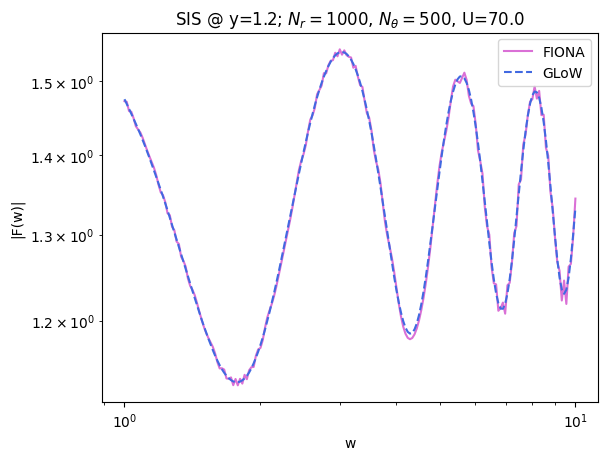

FIONA time (single run): 3.4948 s
GLoW time (single run): 0.0131 s
Speedup (GLoW/FIONA): 0.00×


In [11]:
compare_plot_GLoW_FIONA(lens=SIS(psi0=1.0),
                        w_grid = np.logspace(0., 1., 200),
                        y_star = 1.2,
                        Umax=70.0,
                        eps=1e-12,
                        shared_Umax=True,
                        numexpr_threads=64,
                        track_perf=True,
                        polar_coord=True,
                        n_r=1000,
                        n_theta=500,
                        uniform_theta=False,
                        analytic_tail=True)